# What is an event?

- Primary: TRT
- Secondary: BP
- other authors still welcome!

To start a discussion of the data story behind missing persons reports, it behooves us to define the basic unit of the thing we're talking about. What info must we have to 'observe' a missing person report?

At HRDAG, we typically design a dataset around the question "Who did what to whom?" However, these records don't include perpetrators as the 'who', so we're going to modify this to "Who was last seen where?" This means we should have at least:
- date last seen (AKA date occurred)
- location last seen (AKA address)
- some details on the missing person (this will be covered as its own topic)

Let's go through the data shared by Chicago Police representing documented missing persons reports and dig more into these events.

In [1]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt 

import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# support methods

In [2]:
mp = pd.read_parquet("../import/output/mp.parquet")
extras = pd.read_parquet("../import/input/extras.parquet")

city_beats = pd.read_csv("../import/input/PoliceBeatDec2012.csv")
geobeats = gpd.read_file("../import/input/PoliceBeatsDec2012_1.kmz")
geobeats

FileNotFoundError: [Errno 2] No such file or directory: '../import/output/mp.parquet'

In [4]:
mp.sample(5)[['rd_no', 'date_occurred', 'race', 'sex', 'age_group']]

,rd_no,date_occurred,race,sex,age_group
302401,HS283118,2010-04-29 16:40:00,BLACK,M,youth (10-20)
145528,HJ344336,2003-05-04 19:00:00,WHITE HISPANIC,F,youth (10-20)
208686,F452379,2000-07-25 18:20:00,WHITE,M,youth (10-20)
187291,G433946,2001-07-23 15:00:00,BLACK,F,youth (10-20)
38422,JC366146,2019-07-26 21:45:00,BLACK,M,adult (21-59)


### person identifiers & the `rd` field
When the Chicago Police Department is made aware of a report of a missing person, policy dictates that an officer goes to the scene (or takes a call in the station?) and verifies whether the report is a "Bona Fide" missing persons case. If it is, the officer is meant to generate a Missing Person Incident Report for each individual involved.

Importantly, each Incident Report created by CPD has its own `rd` or record number, which can be treated as a unique identifier for each unique person in the event - _if it's true that only one person was described in the Incident Report._ As we go through the records shared by CPD, we observe a couple dozen reports between 1 January 2000 and 31 December 2021 for which it appears this is not the case.

In [5]:
# how many unique `rd` numbers do we observe?
len(mp.rd_no.unique())

355053

For example, `rd_no` 'JA172886' has the same last seen date and last seen location in several rows of data, but the person details describe two distinct individuals:

* Person A is a 32 year old person born in 1985, no race documented
* Person B is a 22 year old Black person born in 1995

If we were to look only at this data and speculate about possible explanations, we could imagine that an officer got some poor or incomplete information initially, and later received new information about the case and updated the incident to describe the correct individual. Maybe the initial filing had typos in the age and birth year, and those were updated accurately. In either case, one of those persons described is not a real MP, and we should disregard those records.

Alternatively, if we do not assume that policy is always followed, then we can believe that this is an example of a record number being assigned to more than one missing person. But we want to be more scientific about this process than a simple guess, so to follow up on our theory, we submitted FOIA requests for a sample of the `rd_no`s where we believed more than one human was described in the same Incident Report, including JA172886. 
In the case of JA172886, there is a handwritten Incident Report including a narrative field, as well as a digital Supplementary Incident Report. In the narrative and digital records, two distinct humans are described as the subjects of the investigation. One is a 32 year old female with no documented race and the other is a 22 year old Black female. 

In [6]:
base_demo = ['rd_no', 'date_occurred', 'race', 'sex', 
             'age', 'age_group', 'year_of_birth',]
vc_cols = [col for col in extras.columns if ('vc_' in col) & (any(extras[col]))]
shared_rd = extras.loc[(extras.race.str.contains("|")) | 
                       (extras.sex.str.contains("|")) | 
                       (extras.age.str.contains("|")) | 
                       (extras.age_group.str.contains("|")),
                       base_demo]
# how many unique `rd` numbers are candidates for being shared by multiple missing humans?
shared_rd.shape[0]

94

In [7]:
# preview sample of the candidate records
shared_rd.sample(10)

,rd_no,date_occurred,race,sex,age,age_group,year_of_birth
182325,JD339930,None,WHITE|WHITE HISPANIC,None,None,None,None
17781,HK751589,None,None,None,15.0|16.0,None,1988|1989
40920,HJ723804,None,None,None,14.0|15.0,None,None
103717,G460556,None,None,F|M,3.0|8.0|21.0,0-9|17-30,1979|1997|2000
266169,F125169,None,None,None,17.0|18.0,None,1981|1982
117207,JC140559,None,BLACK|WHITE,None,None,None,None
92545,F151535,None,BLACK|WHITE HISPANIC,None,None,None,None
188660,HL306817,None,BLACK|WHITE,None,None,None,None
232489,HH123520,None,None,None,12.0|17.0,None,1984|1989
178079,HN291179,None,None,None,14.0|15.0,None,None


In [8]:
# if we ignore `rd`, how many records would be flagged as sharing `date_occurred` and `address`?
mp.shape[0] - mp.loc[mp.address.str.strip() != "CHICAGO", 
                     ['date_occurred', 'address']
                    ].drop_duplicates().shape[0]

17254

- one possible explanation is that records sharing a last seen date and address represent events where more than one person was reported missing, and CPD correctly assigned distinct `rd` numbers for each individual. If true, these records will be handled correctly by our data processing pipeline and each human will be represented in our final table.
- we have also been told by staff at foster and group homes (who are often the ones making these reports for the youth in their care) that sometimes when they call to get updates on a previous report and provide the assigned `rd` they had been given originally, they are told by a representative that "that is no longer the `rd` number" for that case. In these instances, they're often given a new `rd` that is supposedly assigned to the original report. If true, this creates a problem of overrepresenting certain cases, as well as their associated demographics and things like area occurred, which can impact our later summaries.

### date occurred
- talk about date last seen, date occurred
- **does the number of reports change in the two decades we observe?** frequency of reports overtime

In [9]:
mp.date_occurred.describe()

count                           355053
mean     2009-08-25 20:11:05.299659264
min                2000-01-01 01:00:00
25%                2004-03-31 07:00:00
50%                2008-09-24 07:30:00
75%                2014-07-07 15:30:00
max                2023-04-11 21:55:00
Name: date_occurred, dtype: object

<Axes: xlabel='date_occurred'>

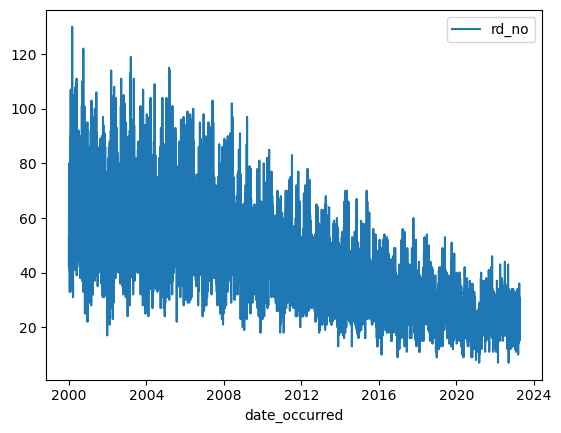

In [10]:
mp[['rd_no', 'date_occurred']].groupby(mp.date_occurred.dt.date).count()[['rd_no']].plot()

### location
- talk about last seen location, address, beat (or district) occurred
- **do certain areas of Chicago have more missing persons reports than others?** cross beat occurred with monthly counts of new rdnos

#### what are the valid district, sector, and beat values?

In [11]:
dists = city_beats.DISTRICT.unique()
sects = city_beats.SECTOR.unique()
beats = city_beats.BEAT.unique()

# note: sectors and beats both appear in range (0, 5) inclusive (shown in later step)
for i in range(0, max(dists)+1):
    print(f'{i} in city_dists:\t{i in dists}')

0 in city_dists:	False
1 in city_dists:	True
2 in city_dists:	True
3 in city_dists:	True
4 in city_dists:	True
5 in city_dists:	True
6 in city_dists:	True
7 in city_dists:	True
8 in city_dists:	True
9 in city_dists:	True
10 in city_dists:	True
11 in city_dists:	True
12 in city_dists:	True
13 in city_dists:	False
14 in city_dists:	True
15 in city_dists:	True
16 in city_dists:	True
17 in city_dists:	True
18 in city_dists:	True
19 in city_dists:	True
20 in city_dists:	True
21 in city_dists:	False
22 in city_dists:	True
23 in city_dists:	False
24 in city_dists:	True
25 in city_dists:	True
26 in city_dists:	False
27 in city_dists:	False
28 in city_dists:	False
29 in city_dists:	False
30 in city_dists:	False
31 in city_dists:	True


In [12]:
sects

array([1, 0, 5, 3, 2])

In [13]:
beats

array([1, 0, 5, 3, 2])

#### do all the beats we observe match the city's data? any invalid?

In [14]:
mp['short_beat_occurred'] = mp.beat_occurred.str.len() < 3
mp['short_beat_assigned'] = mp.beat_assigned.str.len() < 3

print('improperly short beat_occurred:\t', mp.short_beat_occurred.sum())
print('improperly short beat_assigned:\t', mp.short_beat_assigned.sum())

improperly short beat_occurred:	 0
improperly short beat_assigned:	 2


In [15]:
mp.loc[mp.beat_assigned.str.len() < 3, ['rd_no', 'beat_occurred', 'beat_assigned', 
                                        'race', 'sex', 'age', 'age_group', 'address', 
                                        'status', 'tta_group', 'ttc_group']]

,rd_no,beat_occurred,beat_assigned,race,sex,age,age_group,address,status,tta_group,ttc_group
95583,HS318761,111,3N,None,None,NaN,None,"2XX S CANAL ST, CHICAGO",CLOSED NON-CRIMINAL,None,MISSING
250341,HJ104231,1111,11,BLACK,F,17.0,youth (10-20),"44XX W THOMAS ST, CHICAGO",CLOSED NON-CRIMINAL,None,MISSING


#### review valid beats

In [16]:
beats = mp[['rd_no', 'address', 'beat_occurred', 'beat_assigned']].copy()
beats.loc[beats.beat_assigned.str.len() == 3, 'beat_assigned'] = "0" + beats.beat_assigned
beats.loc[beats.beat_assigned.str.len() < 3, 'beat_assigned'] = None
beats

,rd_no,address,beat_occurred,beat_assigned
0,F012033,"63XX S KING DR, CHICAGO",312,0312
1,F021758,"17XX N DRAKE AV, CHICAGO",1422,2502
2,F094577,"26XX N CALIFORNIA AV, CHICAGO",1411,1411
3,F121480,"7XX N ELIZABETH ST, CHICAGO",1324,1341
4,F118317,"48XX S INDIANA AV, CHICAGO",224,0233
...,...,...,...,...
355048,JG221574,"15XX S DRAKE AVE, CHICAGO",1021,9181
355049,JG193453,"106XX S BENSLEY AVE, CHICAGO",434,0402
355050,JG170792,"109XX S VERNON AVE, CHICAGO",513,9154
355051,JF199168,59XX S CICERO AVE,None,0802


In [17]:
# how often is the beat_assigned the same as the occurence beat?
beats.loc[beats.beat_occurred == beats.beat_assigned].shape[0]

76466

In [45]:
# how often do beat_assigned and beat_occurred not match?
round(beats.loc[beats.beat_occurred != beats.beat_assigned].shape[0] / beats.shape[0], 2)

0.78

In [18]:
beats['temp_beat_occurred'] = beats.beat_occurred
beats['city_beat_occurred'] = beats.temp_beat_occurred.str[-1]
beats['temp_beat_occurred'] = beats.temp_beat_occurred.str[:-1]
beats['city_sector_occurred'] = beats.temp_beat_occurred.str[-1]
beats['temp_beat_occurred'] = beats.temp_beat_occurred.str[:-1]
beats['city_district_occurred'] = beats.temp_beat_occurred
beats.drop(columns='temp_beat_occurred', inplace=True)

beats['temp_beat_assigned'] = beats.beat_assigned
beats['city_district_assigned'] = beats.temp_beat_assigned.str[:2]
beats['city_sector_assigned'] = beats.temp_beat_assigned.str[2]
beats['city_beat_assigned'] = beats.temp_beat_assigned.str[3:]
beats.drop(columns='temp_beat_assigned', inplace=True)

In [19]:
beats[['rd_no', 'address', 
       'beat_occurred', 'beat_assigned', 
       'city_district_occurred', 'city_sector_occurred', 'city_beat_occurred', 
       'city_district_assigned', 'city_sector_assigned', 'city_beat_assigned']]

,rd_no,address,beat_occurred,beat_assigned,city_district_occurred,city_sector_occurred,city_beat_occurred,city_district_assigned,city_sector_assigned,city_beat_assigned
0,F012033,"63XX S KING DR, CHICAGO",312,0312,3,1,2,03,1,2
1,F021758,"17XX N DRAKE AV, CHICAGO",1422,2502,14,2,2,25,0,2
2,F094577,"26XX N CALIFORNIA AV, CHICAGO",1411,1411,14,1,1,14,1,1
3,F121480,"7XX N ELIZABETH ST, CHICAGO",1324,1341,13,2,4,13,4,1
4,F118317,"48XX S INDIANA AV, CHICAGO",224,0233,2,2,4,02,3,3
...,...,...,...,...,...,...,...,...,...,...
355048,JG221574,"15XX S DRAKE AVE, CHICAGO",1021,9181,10,2,1,91,8,1
355049,JG193453,"106XX S BENSLEY AVE, CHICAGO",434,0402,4,3,4,04,0,2
355050,JG170792,"109XX S VERNON AVE, CHICAGO",513,9154,5,1,3,91,5,4
355051,JF199168,59XX S CICERO AVE,None,0802,None,None,None,08,0,2


In [20]:
beats.city_district_assigned.value_counts()

city_district_assigned
24    27914
20    20686
07    19556
02    19412
08    19213
      ...  
96        1
32        1
97        1
70        1
5Z        1
Name: count, Length: 71, dtype: int64

### what districts are observed outside of the city's guidelines?
Note: we've been advised that certain district numbers are used for airport zones \
Note 2: as with any region in a period over 20 years, these maps can change, so we should look to see if unexpected values are from a certain point in time.

In [21]:
for dist in beats.city_district_assigned:
    if pd.notnull(dist):
        if not all([char.isdigit() for char in dist]): print(dist)

5C
5C
5C
5Z


In [60]:
beats.loc[(beats.beat_assigned.notnull()) & 
          (beats.beat_assigned.str.contains('C'))
         ].head()

,rd_no,address,beat_occurred,beat_assigned,city_beat_occurred,city_sector_occurred,city_district_occurred,city_district_assigned,city_sector_assigned,city_beat_assigned
4332,HM233065,"97XX S OGLESBY AVE, CHICAGO",431,0404C,1,3,4,04,0,4C
5838,JE194869,"130XX S DREXEL AVE, CHICAGO",533,4578C,3,3,5,45,7,8C
9075,HL179003,"47XX N DRAKE AVE, CHICAGO",1723,1763C,3,2,17,17,6,3C
10615,HJ404858,"30XX W 21ST PL, CHICAGO",1022,1004C,2,2,10,10,0,4C
15227,HM607166,"6XX W DIVISION ST, CHICAGO",1822,4577C,2,2,18,45,7,7C


In [52]:
unk_dist = {}
for dist in beats.city_district_assigned.values:
    if pd.isna(dist): continue
    if (dist.isdigit()):
        clean = int(dist)
        if clean not in city_beats.DISTRICT.unique():
            if clean not in unk_dist: unk_dist[clean] = 1
            else: unk_dist[clean] += 1
unk_dist

{13: 4762,
 72: 14320,
 23: 10058,
 21: 4391,
 73: 326,
 29: 140,
 75: 227,
 45: 652,
 74: 92,
 52: 4129,
 55: 6,
 95: 1,
 83: 33,
 54: 19,
 53: 593,
 91: 538,
 57: 16,
 71: 57,
 51: 20,
 77: 13,
 44: 7,
 56: 3,
 41: 9,
 47: 11,
 93: 2,
 28: 3,
 82: 15,
 81: 17,
 26: 4,
 50: 1,
 76: 1,
 67: 2,
 62: 2,
 92: 5,
 80: 2,
 42: 3,
 0: 1,
 43: 5,
 78: 1,
 65: 2,
 79: 1,
 96: 1,
 32: 1,
 97: 1,
 58: 2,
 70: 1}

### same question but for sectors?

In [54]:
unk_sect = {}
for dist in beats.city_sector_assigned.values:
    if pd.isna(dist): continue
    if (dist.isdigit()):
        clean = int(dist)
        if clean not in city_beats.SECTOR.unique():
            if clean not in unk_sect: unk_sect[clean] = 1
            else: unk_sect[clean] += 1
unk_sect

{4: 18977, 7: 6146, 8: 1350, 6: 436, 9: 1255}

### same question but for beats?
Note: a "BEAT_NUM" is f"{DISTRICT}{SECTOR}{BEAT}"

In [56]:
unk_beat = {}
for dist in beats.city_beat_assigned.values:
    if pd.isna(dist): continue
    if (dist.isdigit()):
        clean = int(dist)
        if clean not in city_beats.BEAT.unique():
            if clean not in unk_beat: unk_beat[clean] = 1
            else: unk_beat[clean] += 1
unk_beat

{4: 42716, 6: 8214, 7: 6198, 9: 2274, 8: 2571, 11: 1, 74: 1, 12: 1}

### chars in beat_nums: an artifact of the supervisor?
Note: we've been advised the alphabetical characters we sometimes in the beat_nums refers to the initial of supervisor of that region at that point in time, since some of the canonical areas are divided that way

In [23]:
# how many unique beat_assigned values contain [A-Z]?
has_char = []
for assn in beats.beat_assigned.unique():
    if pd.isna(assn): continue
    if not all([char.isdigit() for char in assn]): has_char.append(assn)
len(has_char)

801

In [66]:
chars = {}
for val in has_char:
    clean = ''.join([v for v in val[-2:] if not v.isdigit()])
    if not clean: continue
    if clean not in chars: chars[clean] = 1
    else: chars[clean] += 1
chars

{'A': 102,
 'S': 90,
 'R': 429,
 'H': 30,
 'C': 37,
 'Z': 2,
 'D': 27,
 'B': 39,
 'W': 2,
 'F': 7,
 'K': 1,
 'HR': 6,
 'E': 12,
 'I': 2,
 'N': 1,
 'X': 1,
 'L': 2,
 'G': 3,
 'J': 1,
 'M': 2,
 'V': 1}

In [24]:
only_digits = [int(beat) 
               for beat in beats.loc[~beats.beat_assigned.isin(has_char), 'beat_assigned'].unique() 
               if beat]
len(only_digits)

1725

In [68]:
beats.loc[~beats.beat_assigned.isin(has_char), 'beat_assigned'].value_counts().sum()

327389

## multiple statuses observed

In [27]:
extras.loc[extras.vc_status.fillna(False), 'status'].fillna("MISSING").value_counts()

status
CLOSED NON-CRIMINAL|OPEN ASSIGNED              1419
CLOSED NON-CRIMINAL|SUSPENDED                    62
OPEN ASSIGNED|SUSPENDED                          39
CLOSED NON-CRIMINAL|OPEN ASSIGNED|SUSPENDED      14
EX CLEARED CLOSED|OPEN ASSIGNED                   2
CLEARED CLOSED|OPEN ASSIGNED                      2
CLOSED NON-CRIMINAL|OPEN UNASSIGNED               1
EX CLEARED CLOSED|SUSPENDED                       1
Name: count, dtype: int64

In [28]:
temp = base_demo + ['date_officer_arrived', 'closed_date', 'status']
mp.loc[mp.rd_no == 'JD368193', temp]

,rd_no,date_occurred,race,sex,age,age_group,year_of_birth,date_officer_arrived,closed_date,status
5840,JD368193,2020-09-03 10:00:00,BLACK,F,1.0,tender age (0-9),2018,2020-09-15 15:49:00,NaT,CLOSED NON-CRIMINAL


In [29]:
first = pd.read_parquet("../../join/output/versions/first.parquet")
second = pd.read_parquet("../../join/output/versions/second.parquet")
third = pd.read_parquet("../../join/output/versions/third.parquet")
fourth = pd.read_parquet("../../join/output/versions/fourth.parquet")
sixth = pd.read_parquet("../../join/output/versions/sixth.parquet")

In [30]:
first.loc[first.rd_no == 'JD368193', 
          ['rd_no', 'date_occurred', 
           'date_officer_arrived', 'closed_date', 'status']]

,rd_no,date_occurred,date_officer_arrived,closed_date,status
index,,,,,
5945,JD368193,2020-09-03 10:00:00,2020-09-15 15:49:00,NaT,SUSPENDED


In [31]:
second.loc[second.rd_no == 'JD368193', 
           ['rd_no', 'date_occurred', 
            'date_officer_arrived', 'status_date', 'status']]

,rd_no,date_occurred,date_officer_arrived,status_date,status
333489,JD368193,2020-09-03 10:00:00,2020-09-15 15:49:00,2020-11-23 15:20:06,SUSPENDED


In [32]:
third.loc[third.rd_no == 'JD368193', 
           ['rd_no', 'date_occurred', 
            'date_officer_arrived', 'status']]

,rd_no,date_occurred,date_officer_arrived,status
index,,,,
18985,JD368193,2020-09-03 10:00:00,2020-09-15 15:49:00,OPEN ASSIGNED


In [33]:
fourth.loc[fourth.rd_no == 'JD368193', 
           ['rd_no', 'date_occurred', 
            'date_officer_arrived', 'status']]

,rd_no,date_occurred,date_officer_arrived,status
5845,JD368193,2020-09-03 10:00:00,2020-09-15 15:49:00,CLOSED NON-CRIMINAL


In [34]:
sixth.loc[sixth.rd_no == 'JD368193', 
           ['rd_no', 'date_occurred', 
            'date_officer_arrived', 'last_update', 'status']]

,rd_no,date_occurred,date_officer_arrived,last_update,status
365995,JD368193,2020-09-03 10:00:00,2020-09-15 15:49:00,2022-05-18 22:02:00,CLOSED NON-CRIMINAL
365996,JD368193,2020-09-03 10:00:00,2020-09-15 15:49:00,2022-05-18 22:02:00,CLOSED NON-CRIMINAL
365997,JD368193,2020-09-03 10:00:00,2020-09-15 15:49:00,2022-05-18 22:02:00,CLOSED NON-CRIMINAL
